In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

from skimage import io, color, exposure, feature, filters, util, measure
from skimage import img_as_ubyte
from skimage import img_as_float
from skimage.filters import threshold_otsu

from skimage.draw import ellipse_perimeter
from skimage.draw import line
from skimage.draw import ellipse
from skimage.transform import hough_ellipse
from skimage.morphology import reconstruction
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops

from scipy import ndimage as ndi

In [2]:
def show(img):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

    ax1.imshow(img, cmap=plt.cm.gray)

    ax2.hist(img.ravel(), lw=0)
    ax2.set_xlim(0, img.max())
    ax2.set_title('Histogram')
    ax2.set_yticks([])

    plt.show()

Text(0.5, 1.0, 'Input Image')

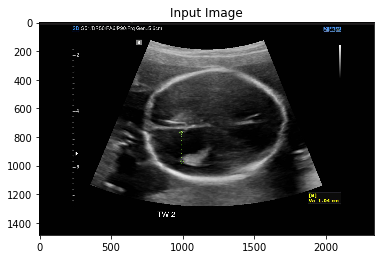

In [3]:
image = io.imread('input_image.jpg')
plt.imshow(image)
plt.title('Input Image')

satuan resize = 6


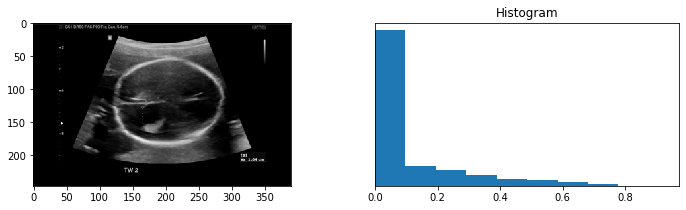

dtype('float64')

In [4]:
from skimage.transform import resize

input_img = image[:,:,0]

# sr = satuan resized
sr = 2
ix = input_img.shape[0]

if ix >=500:
    while ix >= 250:
        ix = ix // (sr)
        sr = sr+2
    print('satuan resize =', sr)
    image_resized = resize(input_img, (input_img.shape[0] // sr, input_img.shape[1] // sr), anti_aliasing=True)
    image_resized2 = resize(input_img, (input_img.shape[0] // sr, input_img.shape[1] // sr), anti_aliasing=True)
else:
    print('Sumbu Y tidak mencapai 1000 pixel, resize tidak dilakukan.')
    image_resized = input_img
    image_resized2 = input_img

show(image_resized)
image_resized.dtype
#io.imsave("8_resize.jpg", np.uint8(image_resized*255))

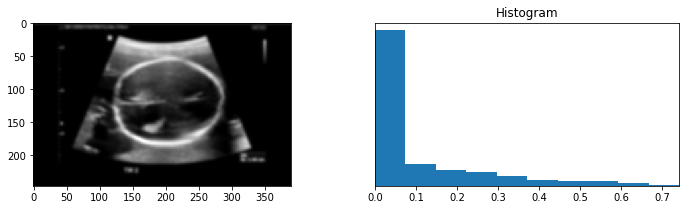

In [5]:
g = filters.gaussian(image_resized, 2, multichannel=False)
show(g)
#io.imsave("8_gaussian.jpg", np.uint8(g*255))

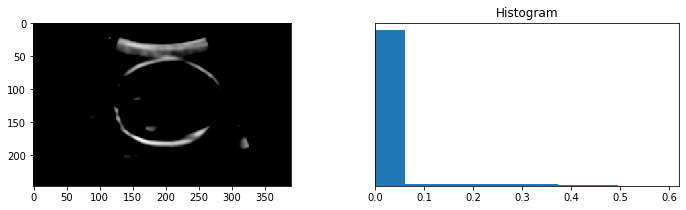

In [6]:
hasil_ex = exposure.rescale_intensity(g, in_range=(0.4,0.95), out_range=(0,1))

show(hasil_ex)
#io.imsave("8_rescaleintensity.jpg", np.uint8(hasil_ex*255))

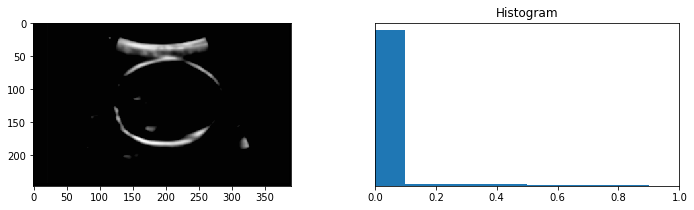

In [7]:
hasil_ex = hasil_ex / hasil_ex.max()
hasil_ex = 255 * hasil_ex
img = hasil_ex.astype(np.uint8)

clahe = exposure.equalize_adapthist(img)
show(clahe)
#io.imsave("8_clahe.jpg", np.uint8(clahe*255))

Text(0.5, 1.0, 'Sobel Edge Filtering')

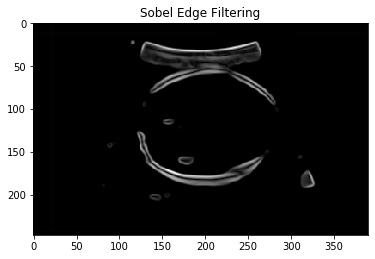

In [8]:
edges = filters.sobel(clahe)
plt.imshow(edges, cmap='gray')
plt.title('Sobel Edge Filtering')
#io.imsave("8_sobel.jpg", np.uint8(edges*255))

Text(0.5, 1.0, 'Hysteresis Threshold Filtering')

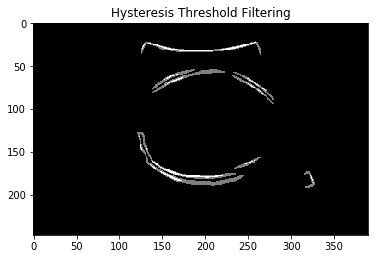

In [9]:
low = 0.14
high = 0.3

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)
plt.imshow(hight + hyst, cmap='gray')
plt.title('Hysteresis Threshold Filtering')
#io.imsave("8_hysteresisthreshold.jpg", np.uint8((hight + hyst)*255))

Text(0.5, 1.0, 'Canny Edge Filtering')

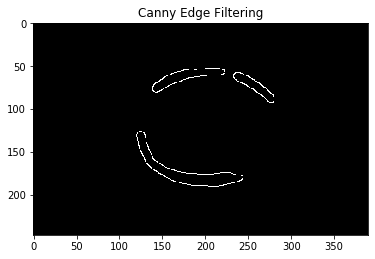

In [10]:
edges2 = feature.canny(hight + hyst, sigma=3.8,
              low_threshold=0.1, high_threshold=0.71)
plt.imshow(edges2, cmap='gray')
plt.title('Canny Edge Filtering')
#io.imsave("8_canny.jpg", np.uint8(edges2*255))

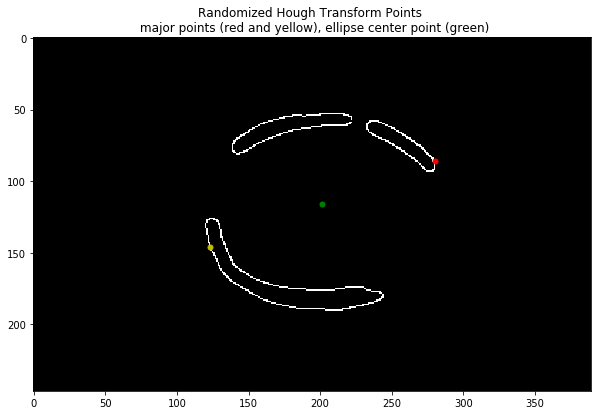

In [11]:
x, y = np.where(edges2[...]>=1)
coords = np.column_stack((x,y))

n = len(coords)
maks = 0

for i in range(0,n):
    X1 = coords[i][1]
    Y1 = coords[i][0]
    for j in range(1,n):
        X2 = coords[j][1]
        Y2 = coords[j][0]
        jarak = math.sqrt((X2 - X1)**2 + (Y2 - Y1)**2)
        if jarak > maks:
            maks = jarak
            x1 = X1
            y1 = Y1
            x2 = X2
            y2 = Y2

x0 = (x1+x2)/2
y0 = (y1+y2)/2

fig, (ax1) = plt.subplots(1, 1, figsize = (10,8))
ax1.imshow(edges2,cmap='gray')
ax1.set_title('Randomized Hough Transform Points \n major points (red and yellow), ellipse center point (green)')
ax1.plot(x1,y1,'or', markersize=5)
ax1.plot(x2,y2,'oy', markersize=5)
ax1.plot(x0,y0,'og', markersize=5)

In [12]:
acc = []
max_element = []

In [13]:
jarak1 = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
a = (math.sqrt((x2-x1)**2+(y2-y1)**2))/2
alpha = math.atan((y2-y1)/(x2-x1))
for k in range(0,n):
    x3 = coords[k][1]
    y3 = coords[k][0]
    jarak2 = math.sqrt((x3 - x0)**2 + (y3 - y0)**2)
    if (jarak2 >= 60) and (jarak2 < a):
        d = jarak2
        #print(a,d)
        f1 = math.sqrt((x3 - x1)**2 + (y3 - y1)**2)
        f2 = math.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        if f1<f2:
            f = f1
        elif f1>f2:
            f = f2
        cos_teta = ((a**2) + (d**2) - (f**2))/(2 * a * d)
        if cos_teta<1:
            sin_teta = math.sqrt(1-(cos_teta**2))
            b = math.sqrt(((a**2) * (d**2) * (sin_teta**2))/((a**2) - (d**2) * (cos_teta**2)))
            #print(b)
            acc.append(b)
    if len(acc) >= 1:
        max_element.append(max(acc))
        result = np.argmax(acc)
        #print(max_element)

In [14]:
semimajor = a
semiminor = max(max_element)
print(semimajor, semiminor)

84.03719414640163 83.5482876030483


dtype('float64')

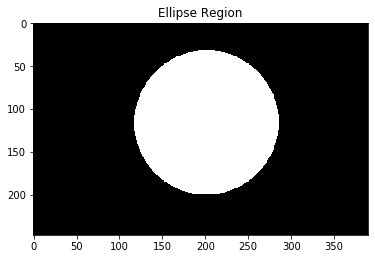

In [15]:
konstruksi_elips = np.zeros((edges2.shape[0],edges2.shape[1]))

rr, cc = ellipse(y0, x0, semiminor, semimajor, konstruksi_elips.shape, rotation=(-alpha))
konstruksi_elips[rr,cc] = 255
plt.imshow(konstruksi_elips, cmap='gray')
plt.title('Ellipse Region')

label_img = label(konstruksi_elips)
regions = regionprops(label_img, coordinates='rc')
konstruksi_elips.dtype

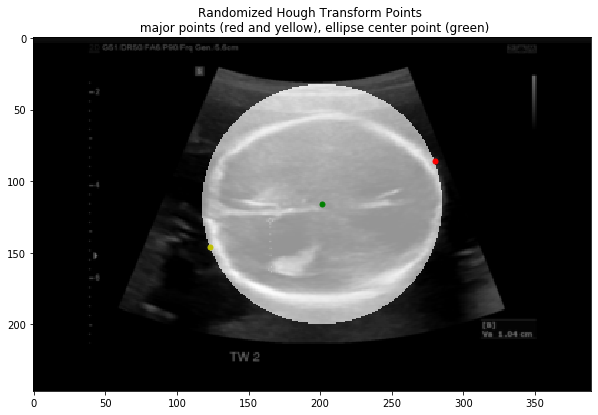

In [16]:
background = image_resized.copy()
foreground = konstruksi_elips.copy()
output = image_resized.copy()

alfa = 1 #transparency parameter
beta = 0.005

test = cv2.addWeighted(background,alfa,foreground,beta,0,output)

fig, (ax1) = plt.subplots(1, 1, figsize = (10,8))
ax1.imshow(edges2,cmap='gray')
ax1.set_title('Randomized Hough Transform Points \n major points (red and yellow), ellipse center point (green)')
ax1.imshow(test, cmap='gray')
ax1.plot(x1,y1,'or', markersize=5)
ax1.plot(x2,y2,'oy', markersize=5)
ax1.plot(x0,y0,'og', markersize=5)

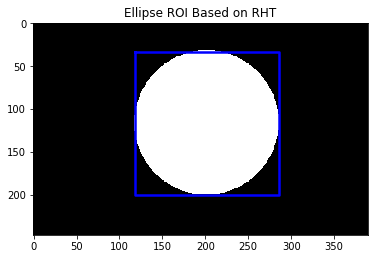

In [17]:
fig, ax = plt.subplots()
ax.imshow(konstruksi_elips, cmap=plt.cm.gray)
ax.set_title('Ellipse ROI Based on RHT')

for props in regions:
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

plt.show()

dtype('float64')

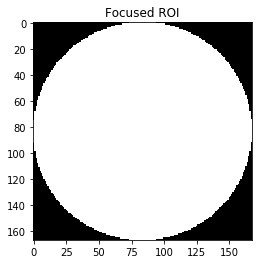

In [18]:
ROI = konstruksi_elips[minr:maxr,minc:maxc]
plt.imshow(ROI,cmap='gray')
plt.title('Focused ROI')
ROI.dtype

In [19]:
label_img_ROI = label(ROI)
regions_ROI = regionprops(label_img_ROI, coordinates='rc')

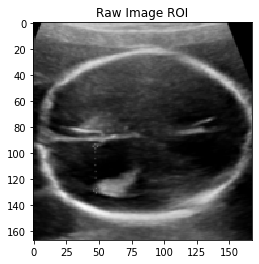

In [20]:
ori_roi = image_resized2[minr:maxr,minc:maxc]
plt.imshow(ori_roi,cmap='gray')
plt.title('Raw Image ROI')

ori_roi = 255 * ori_roi

In [21]:
if(len(ori_roi.shape)<3):
    Z = ori_roi.reshape((-1,1))
elif len(ori_roi.shape)==3:
    Z = ori_roi.reshape((-1,3))

In [22]:
# convert to np.float32
Z = np.float32(Z)
Z.dtype

dtype('float32')

In [23]:
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

Text(0.5, 1.0, 'CLustered Image \n K = 2')

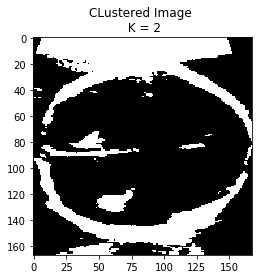

In [24]:
# Now convert back into uint8, and make original image
center = np.uint8(center)
labels = label.flatten()
res = center[labels]
Clustered_Image = res.reshape((ori_roi.shape))
plt.imshow(Clustered_Image,cmap='gray')
plt.title('CLustered Image \n K = 2')

In [25]:
x, y = np.where(Clustered_Image[...] >= 120)
image_seg=np.zeros((Clustered_Image.shape[0],Clustered_Image.shape[1]))

rr, cc = x,y
image_seg[rr,cc] = 255

dtype('uint8')

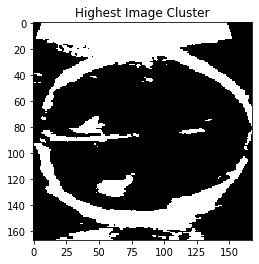

In [26]:
inpc = image_seg.astype(np.uint8)
plt.imshow(inpc,cmap='gray')
plt.title('Highest Image Cluster')
inpc.dtype

4600
4
7
1
9
7
13
1
2
2
2
8
442
7
52
24
8
10
2434
1
1
6
283
2
1
2
257
74
5
9


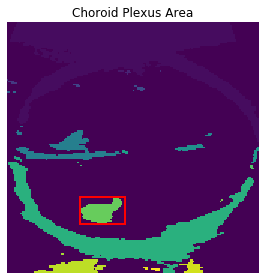

In [27]:
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

label_image = label(inpc)

low = 270 #1000
high = 300 #1200

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(label_image)
ax.set_title('Choroid Plexus Area')

for region in regionprops(label_image):
    # take regions with large enough areas
    print(region.area)
    if (region.area >= low) and (region.area < high):
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ROI Contour')

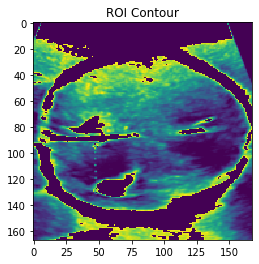

In [28]:
# Finding contours for the thresholded image
contours, hierarchy = cv2.findContours(inpc, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(ori_roi, contours, -1, (0,255,0), -10)
plt.imshow(ori_roi)
plt.title('ROI Contour')

In [29]:
lowc = low-(low*0.1)
highc = high+(high*0.1)

for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if (area >= lowc) and (area <= highc):
        CP = i
        LA = area
        print('array ke = ', i, '| luas area = ', LA)
        break

array ke =  8 | luas area =  244.5


Text(0.5, 1.0, 'CP Contour')

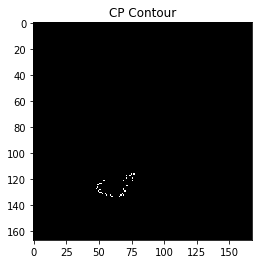

In [30]:
image_seg_hasil=np.zeros((ROI.shape[0],ROI.shape[1]))

for j in range(len(contours[CP])):
    rr = contours[CP][j][0][1]
    cc = contours[CP][j][0][0]
    image_seg_hasil[rr,cc] = 255

plt.imshow(image_seg_hasil,cmap='gray')
plt.title('CP Contour')

Text(0.5, 1.0, 'Convex Hull Area')

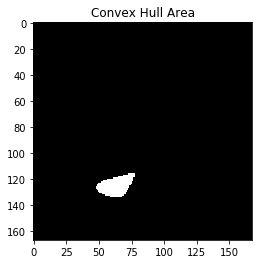

In [31]:
hull = cv2.convexHull(contours[CP])
cv2.drawContours(image_seg_hasil, [hull], -1, (255,0,0), -3)

plt.imshow(image_seg_hasil, cmap='gray')
plt.title('Convex Hull Area')

VOLUME CONVEX HULL =  346


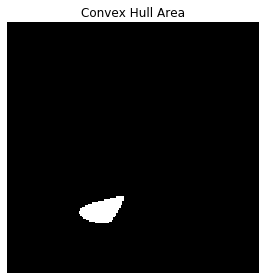

In [32]:
label_image2 = label(image_seg_hasil)

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(label_image2, cmap='gray')
ax.set_title('Convex Hull Area')

for region in regionprops(label_image2):
    VCH = region.area
    print('VOLUME CONVEX HULL = ', VCH)
    

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [33]:
solidity = (LA/VCH)
error_solidity = ((1-solidity)/1) * 100
print('Solidity = ', solidity, '| Error Percentage = ', error_solidity, '%')

Solidity =  0.7066473988439307 | Error Percentage =  29.335260115606932 %


Text(0.5, 1.0, 'ROI Compared to CP')

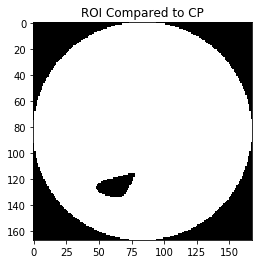

In [34]:
invert_segmen = util.invert(image_seg_hasil)
CP_point_img = invert_segmen+ROI
plt.imshow(CP_point_img,cmap='gray')
plt.title('ROI Compared to CP')

In [35]:
xluarlingkar, yluarlingkar = np.where(ROI[...]<=0)
coordsluar = np.column_stack((xluarlingkar, yluarlingkar))

xcp, ycp = np.where(image_seg_hasil[...]>=255)
coordscp = np.column_stack((xcp, ycp))
print(coordsluar)

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [166 165]
 [166 166]
 [166 167]]


In [36]:
jarak_min = math.sqrt((coordsluar[0][1]-coordscp[0][1])**2 + (coordsluar[0][0]-coordscp[0][0])**2)
print(jarak_min)

137.05838172107534


In [37]:
x_ll = []
y_ll = []
x_cp =[]
y_cp = []

for i in range(0,len(coordsluar)):
    xx = coordsluar[i][1]
    yy = coordsluar[i][0]
    for i in range(0,len(coordscp)):
        xx2 = coordscp[i][1]
        yy2 = coordscp[i][0]
        jarakini = math.sqrt((xx-xx2)**2 + (yy-yy2)**2)
        #print(jarakini)
        if jarakini < jarak_min:
            jarak_min = jarakini
            x_ll.append(xx)
            y_ll.append(yy)
            x_cp.append(xx2)
            y_cp.append(yy2)

In [38]:
x_ll = x_ll[len(x_ll)-1]
y_ll = y_ll[len(y_ll)-1]
x_cp = x_cp[len(x_cp)-1]
y_cp = y_cp[len(y_cp)-1]

Text(0.5, 1.0, 'Shortest Line in Between Black Area (yellow)')

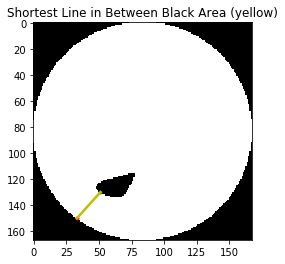

In [39]:
fig, ax = plt.subplots()
ax.plot(x_ll, y_ll, 'r.')
ax.plot(x_cp, y_cp, 'g.')
ax.plot((x_ll, x_cp), (y_ll, y_cp), '-y', linewidth=2.5)
ax.imshow(CP_point_img, cmap=plt.cm.gray)
ax.set_title('Shortest Line in Between Black Area (yellow)')

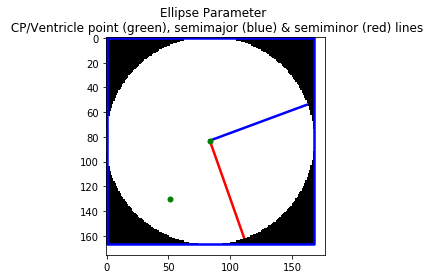

In [40]:
fig, ax = plt.subplots()
ax.imshow(ROI, cmap=plt.cm.gray)
ax.set_title('Ellipse Parameter \n CP/Ventricle point (green), semimajor (blue) & semiminor (red) lines')

for props in regions_ROI:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = int(x0 + math.cos(orientation) * 0.5 * props.minor_axis_length) #minor
    y1 = int(y0 - math.sin(orientation) * 0.5 * props.minor_axis_length) #minor
    x2 = int(x0 - math.sin(orientation) * 0.5 * props.major_axis_length) #mayor
    y2 = int(y0 - math.cos(orientation) * 0.5 * props.major_axis_length) #mayor

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-b', linewidth=2.5)
    ax.plot(x_cp, y_cp, 'g.', markersize=10) # titik CP
    ax.plot(x0, y0, '.g', markersize=10)

    minr_r, minc_r, maxr_r, maxc_r = props.bbox
    bx = (minc_r, maxc_r, maxc_r, minc_r, minc_r)
    by = (minr_r, minr_r, maxr_r, maxr_r, minr_r)
    ax.plot(bx, by, '-b', linewidth=2.5)

plt.show()
HW = 0.5 * props.minor_axis_length

In [41]:
def slope(x1,y1,x2,y2):
    a = y1-y2
    b = x1-x2
    if a == 0:
        m = print('gradien adalah 0 karena garis sejajar sumbu x')
        searched_points_paralel_x(x_cp,y_cp)
    elif b == 0:
        m2 = print('gradien tak terhingga karena garis sejajar sumbu y')
        searched_points_paralel_y(x_cp,y_cp)
    else:
        m1 = a/b
        m2 = (-1/m1)
        return searched_points(m2,x_cp,y_cp)

def searched_points_paralel_x(xi,yi):
    sp = []
    for x in range(CP_point_img.shape[1]):
        y = yi
        sp.append([x,y])
    return sp

def searched_points_paralel_y(xi,yi):
    sp = []
    for y in range(CP_point_img.shape[0]):
        x = xi
        sp.append([x,y])
    return sp

def searched_points(m,xi,yi):
    sp = []
    for x in range(CP_point_img.shape[1]):
        y = int(abs(((m*x)-(m*xi))+yi))
        sp.append([x,y])
    return sp

sp = slope(x2,y2,x0,y0)
#print(sp)

In [42]:
def available_points(x1,y1,x2,y2):
    ap = []
    a = x2-x1
    b = y2-y1
    for x in range(CP_point_img.shape[1]):
        y = int(((b*x-b*x1)+a*y1)/a)
        ap.append([x,y])
    return ap

ap = available_points(int(x2),int(y2),int(x0),int(y0))
#print(ap)

In [43]:
mp = np.zeros((1))
for x in sp:
    for y in ap:
        if x == y:
            mp = x
        else:
            for i in range(len(sp)):
                if (sp[i][1] == ap[i][1]) or (sp[i][1]+1 == ap[i][1]) or (sp[i][1]+2 == ap[i][1]):
                    mp = sp[i]
                    break

print(mp)
#print(cpx,cpy)

[39, 97]


In [44]:
xp = mp[0]
yp = mp[1]

Text(0.5, 1.0, 'Semimajor (blue), LVW (yellow) & HW (red)')

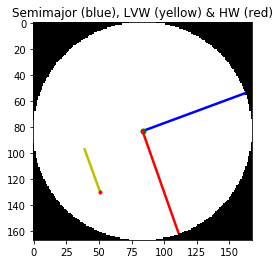

In [45]:
fig, ax = plt.subplots()
ax.plot((x_cp, xp), (y_cp, yp), '-y', linewidth=2.5) #51,75 #49,72
ax.plot((x2, x0), (y2, y0), '-b', linewidth=2.5)
ax.plot(x0, y0, '.g', markersize=10)
ax.plot(x_cp, y_cp, 'r.')
ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
ax.imshow(ROI, cmap=plt.cm.gray)
ax.set_title('Semimajor (blue), LVW (yellow) & HW (red)')

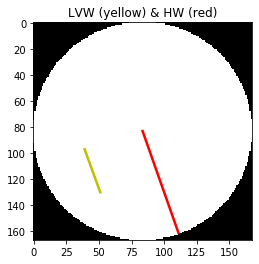

In [46]:
fig, ax = plt.subplots()
ax.plot((x_cp, xp), (y_cp, yp), '-y', linewidth=2.5)
ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
ax.set_title('LVW (yellow) & HW (red)')
ax.imshow(ROI, cmap=plt.cm.gray)

In [47]:
def distance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [48]:
LVW = distance(x_cp,y_cp,xp,yp)

In [49]:
# 1 pixel 91dpi = 0.264583333 mm

LVW_Final = LVW*sr
#print('Lateral Ventricle Width = ', LVW_Final, 'mm')
print('Lateral Ventricle Width = ', LVW, 'px')

HW_Final = HW*sr
#print('Hemisphreci Width = ', HW_Final, 'mm')
print('Hemisphreci Width = ', HW, 'px')

Ratio = (LVW_Final/HW_Final)*100
print('Ratio = ', Ratio, '%')

Lateral Ventricle Width =  35.11409973215888 px
Hemisphreci Width =  83.55794890147703 px
Ratio =  42.02364968719113 %
